https://github.com/avidale/encodechka тут сравнение моделей относительно задачи семантического сходства текстов

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00


In [ ]:
!pip install emoji==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=8efc202c60e5e6e3f6c9078f1b4bac0348fc759069e7f158d7653d38db07f51a
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from bs4 import BeautifulSoup
import torch
import numpy as np
import re
import emoji

In [ ]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [ ]:
def preprocess_text(text: str) -> str:
  soup = BeautifulSoup(text, features="html.parser")
  text = soup.get_text()
  text = text.replace("\n", "")
  return text

In [ ]:
def remove_url(text: str) -> str:
  return re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', ' ', text)

##  data

In [ ]:
df_post = pd.read_csv("post10k.csv", encoding="utf-8")
df_post.head(5)

,Unnamed: 0,msg_id,entity_id,text,content_type,keyboard,silent,has_media_spoiler,posted
0,0,5301,1002094480,🤤 Яркие фотокарточки первой победы в году уже ...,media_group,NaN,0,0,2023-01-09 17:10:06
1,1,5302,1002094480,💥 Кто стал обладателем игровой майки и брендир...,text,NaN,0,0,2023-01-10 14:00:11
2,2,5304,1002094480,🤫💪🏼Тренируемся в традиционном режиме \n\nГотов...,video,NaN,0,0,2023-01-10 14:40:25
3,3,5305,1002094480,<b>Проведи год вместе с Динамо-Ак Барс </b>📆💙\...,video,NaN,0,0,2023-01-11 12:30:23
4,4,5306,1002094480,<b>Динамо-Ак Барс 🆚 Минчанка\n\n</b>Кто<b> </b...,photo,NaN,0,0,2023-01-11 16:00:06


In [ ]:
df_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11439 entries, 0 to 11438
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         11439 non-null  int64 
 1   msg_id             11439 non-null  int64 
 2   entity_id          11439 non-null  int64 
 3   text               11083 non-null  object
 4   content_type       11439 non-null  object
 5   keyboard           94 non-null     object
 6   silent             11439 non-null  int64 
 7   has_media_spoiler  11439 non-null  int64 
 8   posted             11439 non-null  object
dtypes: int64(5), object(4)
memory usage: 804.4+ KB


In [ ]:
df_post = df_post.dropna(subset=['text'])

In [ ]:
df_post = df_post.reset_index(drop=True)



In [ ]:
df_post.text = df_post.text.apply(lambda x: preprocess_text(x))
df_post.text = df_post.text.apply(lambda x: remove_url(x))
df_post['text'] = df_post["text"].apply(lambda x: emoji.replace_emoji(x))

<ipython-input-4-f2e004724d36>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features="html.parser")


## intfloat/multilingual-e5-large

In [ ]:
tokenizer_e5 = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model_e5 = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [ ]:
def e5_sts(sent1: str, sent2: str) -> float:
    # Tokenize the input texts
    batch_dict = tokenizer_e5([sent1, sent2], max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model_e5(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    # normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    scores = (embeddings @ embeddings.T) * 100
    scores = scores.tolist()
    scores = np.divide(scores, 20)
    return scores[0][1]

In [ ]:
# Tokenize the input texts
batch_dict = tokenizer_e5([df_post.text[223], df_post.text[0]], max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model_e5(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [ ]:
# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings @ embeddings.T) * 100
scores = scores.tolist()

In [ ]:
scores = np.divide(scores, 20)

In [ ]:
scores

array([[5.        , 3.66301117],
       [3.66301079, 5.00000076]])

## sentence-transformers/paraphrase-multilingual-mpnet-base-v2

In [ ]:
sentences = [df_post.text[223], df_post.text[0]]

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
# Load model from HuggingFace Hub
tokenizer_mpnet = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model_mpnet = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')


In [ ]:
def mpnet_sts(sent1: str, sent2: str) -> float:
    sentences = [sent1, sent2]
    # Tokenize sentences
    encoded_input = tokenizer_mpnet(sentences, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
    with torch.no_grad():
        model_output = model_mpnet(**encoded_input)

    # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    # Косинусное сходство
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    scores = (sentence_embeddings @ sentence_embeddings.T) * 100
    scores = scores.tolist()
    scores = np.divide(scores, 20)
    return scores[0][1]

In [ ]:
# Tokenize sentences
encoded_input = tokenizer_mpnet(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model_mpnet(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
# Косинусное сходство
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
scores = (sentence_embeddings @ sentence_embeddings.T) * 100
print(scores.tolist())

[[100.0000228881836, 26.426279067993164], [26.42627716064453, 100.0]]


## navec

In [ ]:
!pip install navec

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=dc28ce8f2c368598aadea7aefd8c4f649352df054dd15314dc3ae25620b16a55
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-10-09 16:21:37--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.4MB/s    in 3.5s    

2023-10-09 16:21:41 (14.4 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
from navec import Navec
from razdel import tokenize
import pymorphy2


morph = pymorphy2.MorphAnalyzer()

In [ ]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
embedding_dim = 300

In [ ]:
def tokenizer_razdel(text):
    navec_words = []
    tokens = [_.text for _ in list(tokenize(text))]

    for word in [morph.parse(_)[0].normal_form for _ in tokens]:
        try:
            navec[word]
            navec_words.append(word)
        except:
            pass
    return navec_words


In [ ]:
def get_sentence_embedding(sentence):
    words = tokenizer_razdel(sentence)
    sentence_len = len(words)
    embedding = np.zeros(embedding_dim)
    for word in words:
        navec[word.lower()]
        embedding += navec[word.lower()]

    return embedding / sentence_len

In [ ]:
navec_sentence_embeddings = []
navec_sentence_embeddings.append(get_sentence_embedding(sentences[0]))
navec_sentence_embeddings.append(get_sentence_embedding(sentences[1]))

In [ ]:
navec_sentence_embeddings = torch.Tensor(np.array(navec_sentence_embeddings))

In [ ]:
# Косинусное сходство
navec_sentence_embeddings = F.normalize(navec_sentence_embeddings, p=2, dim=1)
scores = (navec_sentence_embeddings @ navec_sentence_embeddings.T) * 100
print(scores.tolist())

[[99.99999237060547, 55.540435791015625], [55.540435791015625, 100.00001525878906]]


In [84]:
def navec_avg_sts(sent1: str, sent2: str) -> float:
    navec_sentence_embeddings = [get_sentence_embedding(sent) for sent in [sent1, sent2]]
    navec_sentence_embeddings = torch.Tensor(np.array(navec_sentence_embeddings))
    # Косинусное сходство
    navec_sentence_embeddings = F.normalize(navec_sentence_embeddings, p=2, dim=1)
    scores = (navec_sentence_embeddings @ navec_sentence_embeddings.T) * 100
    scores = scores.tolist()
    scores = np.divide(scores, 20)
    return scores[0][1]

## load test data

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("stsb_multi_mt", name="ru", split="dev")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
df = pd.DataFrame(dataset)

In [ ]:
df

,sentence1,sentence2,similarity_score
0,Человек в твердой шляпе танцует.,Мужчина в твердой шляпе танцует.,5.00
1,Маленький ребенок едет верхом на лошади.,Ребенок едет на лошади.,4.75
2,Мужчина кормит мышь змее.,Человек кормит змею мышью.,5.00
3,Женщина играет на гитаре.,Человек играет на гитаре.,2.40
4,Женщина играет на флейте.,Человек играет на флейте.,2.75
...,...,...,...
1495,"Ученые доказали, что на Марсе есть вода.",Наса обнаружила воду на Марсе?,2.00
1496,"Пранаб подчеркивает, что государства должны ст...",ВТО: Индия сожалеет о действиях развитых стран,0.00
1497,Фольксваген заносит красный цвет после скандал...,"Жест доброй воли"" Фольксвагена в адрес владель...",2.00
1498,Обама прав: Африка заслуживает лучшего лидерства,"Обама ждет середины семестра, чтобы назвать им...",0.00


## Testing

In [ ]:
def mae(dataframe, func, column_name):
    maes = [np.nan] * len(dataframe)
    for s in range(len(dataframe)):
        ent = dataframe.iloc[s]
        maes[s] = abs(func(ent.sentence1, ent.sentence2) - ent.similarity_score)

    dataframe[column_name] = maes

In [ ]:
df1 = df.copy()

In [ ]:
df1 = df1.iloc[lambda x: x.index % 5 == 0]

In [ ]:
df1.iloc[41]

sentence1                        Мужчина подает торт.
sentence2           Мужчина, приправляющий перепелов.
similarity_score                                 0.75
Name: 205, dtype: object

In [ ]:
for f, colname in ((e5_sts, "e5_mae"), (mpnet_sts, "mpnet_mae"), (navec_avg_sts, "navec_mean_mae")):
    mae(df1, f, colname)

In [ ]:
df1

,sentence1,sentence2,similarity_score,navec_sif_mae,e5_mae,mpnet_mae,navec_mean_mae
0,Человек в твердой шляпе танцует.,Мужчина в твердой шляпе танцует.,5.000,0.000000,0.021395,0.062128,0.271412
5,Женщина режет лук.,Мужчина режет лук.,2.615,2.385000,2.069936,0.946668,2.029321
10,Люди играют в крикет.,Мужчины играют в крикет.,3.200,1.800000,1.654596,1.406906,1.494329
15,Человек что-то находит.,Женщина что-то режет.,0.800,0.272021,3.241681,1.165919,2.428532
20,Женщина готовит яйца.,Женщина что-то готовит.,3.000,2.005983,1.619081,0.680217,0.992305
...,...,...,...,...,...,...,...
1475,Президент Алжира получает терапию после инсуль...,Президент Болгарии пытается выйти из предвыбор...,0.400,0.148485,3.684410,0.769936,1.784677
1480,Предложение Казначейства предусматривает увели...,Казначейство предлагает повысить подоходный на...,4.000,1.000000,0.839022,0.751891,0.162353
1485,Мальдивы начинают голосовать в контролируемом ...,Ударившиеся в кризис Мальдивы провели новый пр...,3.000,0.996651,1.397646,0.640503,0.105276
1490,Назначен новый руководитель миротворческой мис...,ООН берет на себя ответственность за поддержан...,2.000,3.000000,2.555613,1.706604,0.988348


In [ ]:
df1.describe()

,similarity_score,navec_sif_mae,e5_mae,mpnet_mae,navec_mean_mae
count,300.000000,300.000000,3.000000e+02,3.000000e+02,300.000000
mean,2.329728,1.559725,2.051060e+00,8.682562e-01,1.378725
std,1.483120,1.164689,1.196999e+00,6.105161e-01,0.986827
min,0.000000,0.000000,7.629395e-07,7.629395e-07,0.000000
25%,0.950000,0.530939,1.093629e+00,3.983728e-01,0.586351
50%,2.600000,1.388862,1.867515e+00,7.424275e-01,1.145747
75%,3.500000,2.455103,3.145647e+00,1.225935e+00,2.064859
max,5.000000,4.535509,4.131989e+00,2.869203e+00,4.141666


In [ ]:
df1.to_csv('result.csv', sep=',')

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Axes: >

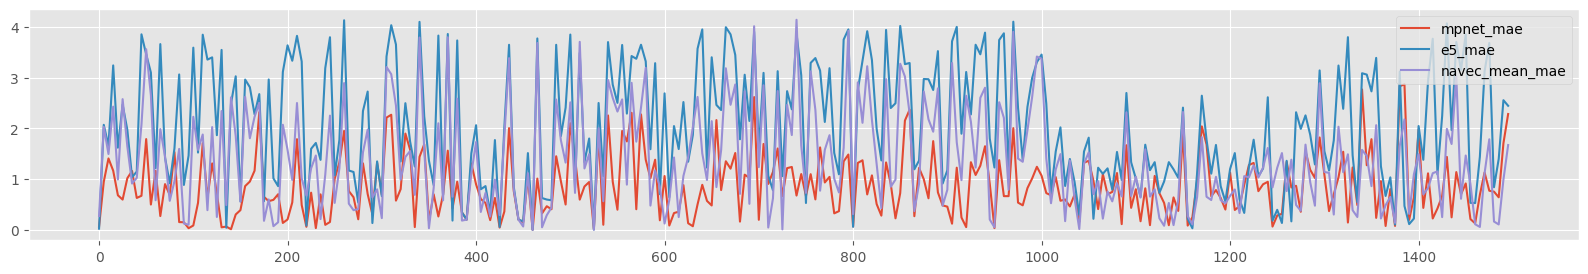

In [ ]:
df1[["mpnet_mae", "e5_mae", "navec_mean_mae"]].plot(figsize=(20,3))